# Determine which pairs of mutated positions are linked, and plot results

**Part 2 of the "linked mutations" analyses.**

In [1]:
%run "Header.ipynb"

In [2]:
import pickle
import networkx as nx
from linked_mutations_utils import (
    MAX_NONLINKED_MUTATED_FRACTION_NONINCLUSIVE, emptyListOf4
)

## Using the computed groups...

### Plot $|Reads(i, j)|$ vs. $\big(|Reads(i, -)| + |Reads(-, j)|\big)$ for all consecutive mutated position pairs $i, j$

Minor considerations, based on how this data was computed in the first linked mutations notebook:

- We have already excluded pairs more than some max distance away from each other (current value is 3 kbp).
- We have already excluded mutated positions with less than some min coverage (current value is 1,000x).

On seq edge_6104.
....................................................................................................
Done with edge_6104!

On seq edge_1671.
...................................................................................................
Done with edge_1671!

On seq edge_2358.
...................................................................................................
Done with edge_2358!


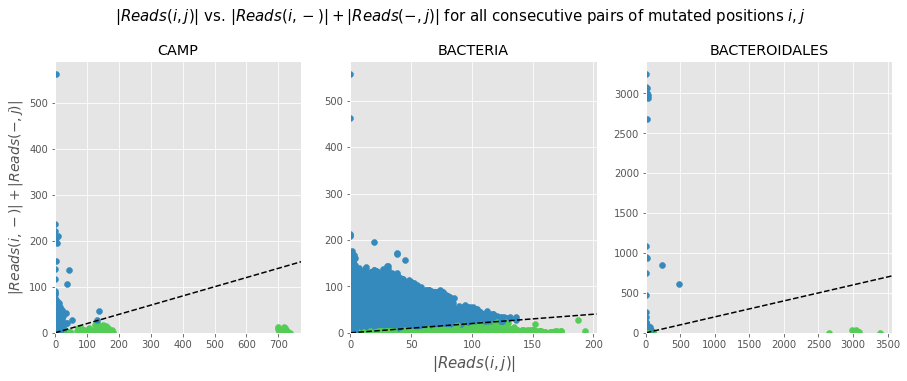

In [3]:
fig, axes = pyplot.subplots(1, 3)
for i, seq in enumerate(SEQS):
    print(f"On seq {seq}.")
    with open(f"pospair2groupcts/{seq}_pospair2groupcts.pickle", "rb") as pf:
        pospair2groupcts = pickle.load(pf)
    
    ax = axes[i]
    seen_left_mutpos = []
    onehundredth = round(len(pospair2groupcts) / 100)
    for ii, pospair in enumerate(sorted(pospair2groupcts.keys()), 1):
        
        # Crude progress bar.
        # This might occasionally print 99 or 101 dots instead of 100 dots per genome, but this is reasonable
        # enough. Just to reassure myself that this hasn't crashed my laptop.
        if ii % onehundredth == 0:
            print(".", end="")
            
        # We only consider _consecutive_ pairs. For example, if the pairs we have are
        # (A, B), (A, C), (B, C), (C, D), (C, E), where the order from left to right in the genome is ABCDE,
        # then we will only consider (A, B), (B, C), (C, D).
        #
        # Since we've sorted the pairs (which in Python defaults to sorting by the first position in each
        # pair, then by the second position), we can only consider pairs where the first position in the
        # pair has not been seen before.
        if len(seen_left_mutpos) == 0 or pospair[0] > seen_left_mutpos[-1]:
            cts = pospair2groupcts[pospair]
            
            # Color pairs that are less than the 0.2 threshold specially (this is the remaining condition
            # for these pairs being linked, although we could also have non-consecutive mutations be linked
            # since the pairs we draw here are just a subset of the total pairs)
            if (cts[1] + cts[2]) < MAX_NONLINKED_MUTATED_FRACTION_NONINCLUSIVE * cts[0]:
                color = "#55cc55"
            else:
                color = SCATTERPLOT_PT_COLOR
                
            ax.scatter(cts[0], cts[1] + cts[2], c=color)
            seen_left_mutpos.append(pospair[0])
            
        elif pospair[0] < seen_left_mutpos[-1]:
            raise ValueError("seen_left_mutpos should be updated in sorted order; something's wrong")
    print(f"\nDone with {seq}!")
    if i < 2:
        print("\n", end="")
    if i == 0:
        ax.set_ylabel("$|Reads(i, -)| + |Reads(-, j)|$", fontsize=14)
    elif i == 1:
        ax.set_xlabel("$|Reads(i, j)|$", fontsize=15)
        
    # Bound the left and bottom of each scatterplot at x = 0 and y = 0
    ax.set_xlim(0)
    ax.set_ylim(0)
    
    # Plot the line y = (MAX_NONLINKED_MUTATED_FRACTION_NONINCLUSIVE) * x
    # Represents the cutoff point for when or not we consider a pair of mutated positions to be linked.
    # Based on https://stackoverflow.com/a/43811762.
    xvals = ax.get_xlim()
    yvals = [MAX_NONLINKED_MUTATED_FRACTION_NONINCLUSIVE * x for x in xvals]
    ax.plot(xvals, yvals, "--", c="#000000")
    
    # Using nonlinear scales apparently breaks the line stuff (or at least it breaks axline, the
    # "official" version of these scales added in a later version of matplotlib)... maybe worth using
    # two rows of plots in the future, where one row is log scales and another is non-log scales?
    # (With just the non-log scales row having the line.)
    #ax.set_xscale("symlog")
    #ax.set_yscale("symlog")
    ax.set_title(seq2name[seq])
    
fig.suptitle(
    "$|Reads(i, j)|$ vs. $|Reads(i, -)| + |Reads(-, j)|$ for all consecutive pairs of mutated positions $i, j$",
    fontsize="15",
    y=1.03
)
fig.set_size_inches(15, 5)
fig.savefig("figs/readsij_scatterplots.png", bbox_inches="tight")

## Define mutated positions as "linked" or not, and then create a graph

__Nodes:__ Mutated positions.

__Edges:__ Connect _linked_ mutated positions.

In [4]:
for i, seq in enumerate(SEQS):
    g = nx.Graph()
    print(f"On seq {seq}...", end=" ")
    with open(f"pospair2groupcts/{seq}_pospair2groupcts.pickle", "rb") as pf:
        pospair2groupcts = pickle.load(pf)
        
    # Adding the same node twice doesn't hurt, so the lazy approach is ok
    # (not calling find_mutated_positions() from the utils file since that requires loading some big
    # JSONs into memory which will bork my laptop)
    for pair in pospair2groupcts:
        g.add_node(pair[0])
        g.add_node(pair[1])
        
        cts = pospair2groupcts[pair]
        if (cts[1] + cts[2]) < MAX_NONLINKED_MUTATED_FRACTION_NONINCLUSIVE * cts[0]:
            g.add_edge(*pair)
            
#         if pair[0] == 1209001 or pair[1] == 1209001:
#             print(pair, cts)
    
    nx.write_graphml(g, f"graphs/{seq}_linked_mutations.graphml")
    print("Wrote out graph!")

On seq edge_6104... Wrote out graph!
On seq edge_1671... Wrote out graph!
On seq edge_2358... Wrote out graph!
